# Snowfall in Les Vosges: study case with La Mauselaine - Gérardmer

**Analysis of snowfall data in La Mauselaine and building of a predictive model for further years.**


In [49]:
# Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Personal scripts
from src.location import Location
from scripts.timesplit import group

# Auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing and cleaning data
Data are imported from an OpenWeather *History Bulk*, and the time period ranges from 01/01/1979 to 01/01/2024.

In [81]:
gerardmer = Location('gerardmer')
data_df = gerardmer.get_data()

## Overview of the data

Total quantity of snowfall by year, showing a decreasing tendency.

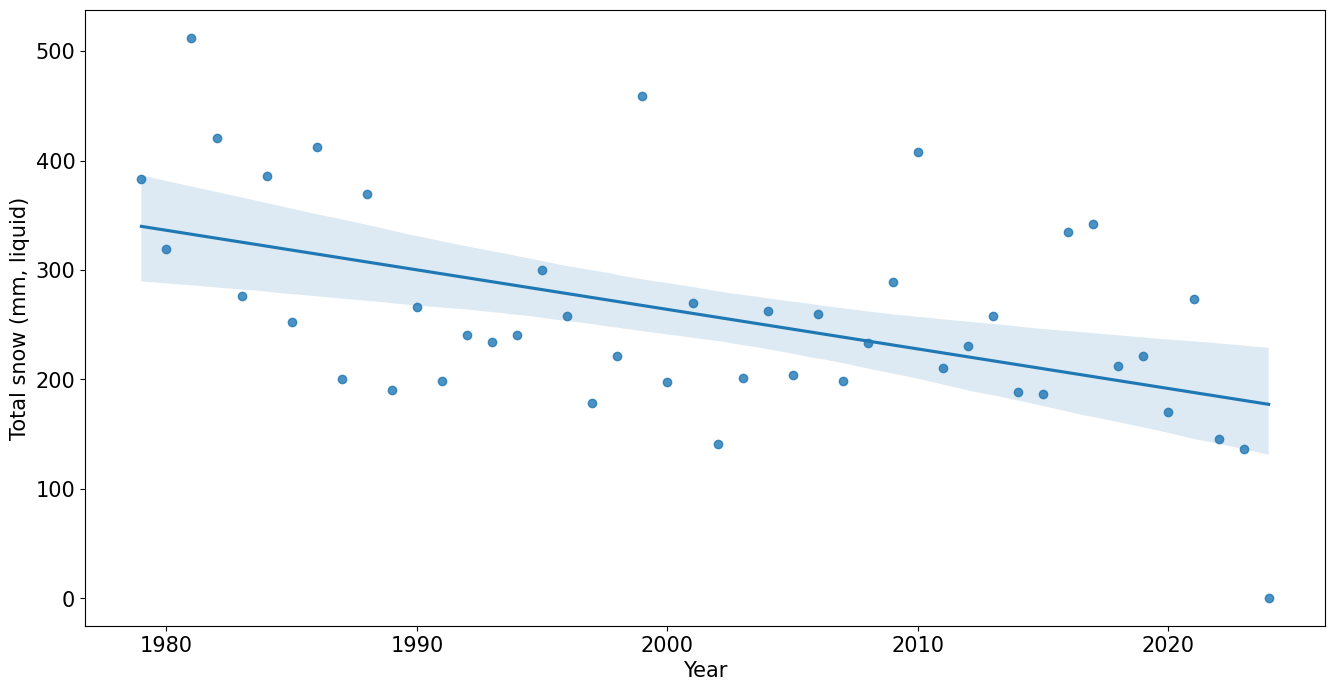

In [75]:
yearly_df = group(data_df, 'year')

fig, axs = plt.subplots(figsize=(16,8));
axs = sns.regplot(x='year', y='snow', data=yearly_df);
axs.set_xlabel("Year");
axs.set_ylabel("Total snow (mm, liquid)");

Average temperature by year, showing an increasing tendency.

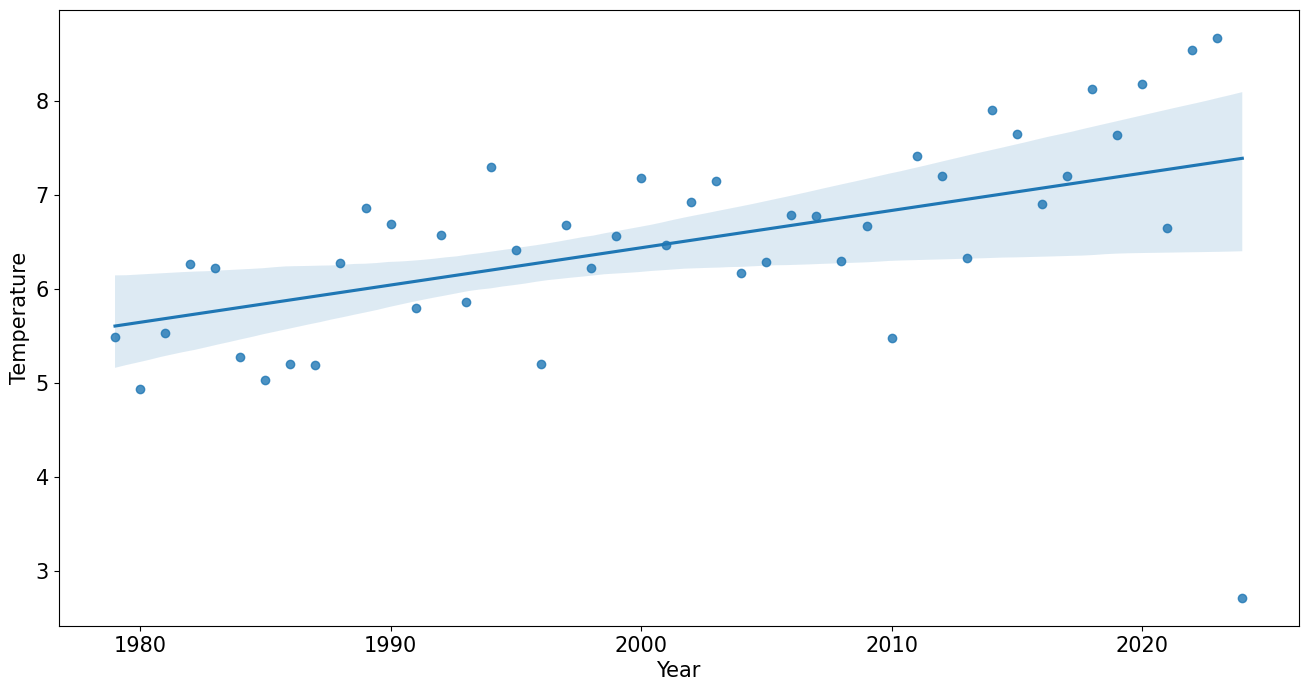

In [108]:
fig, axs = plt.subplots(figsize=(16,8));
axs = sns.regplot(x='year', y='temp', data=yearly_df);
axs.set_xlabel("Year");
axs.set_ylabel("Temperature");

## Snowfalls accross the years

Using data grouped by month.

In [100]:
monthly_df = group(data_df, 'month')
monthly_df.head()

,temp,temp_min,temp_max,pressure,snow,rain,month,season
dt,,,,,,,,
1979-01-31,-5.946694,-17.55,2.79,1015.221774,103.46,0.29,1,Winter
1979-02-28,-1.570461,-10.43,7.14,1011.319940,75.17,46.97,2,Winter
1979-03-31,1.868763,-7.63,12.06,1010.579301,52.22,112.14,3,Spring
1979-04-30,3.473292,-5.31,16.69,1013.238889,25.17,91.31,4,Spring
1979-05-31,8.841599,-4.94,25.06,1017.549731,18.59,109.10,5,Spring


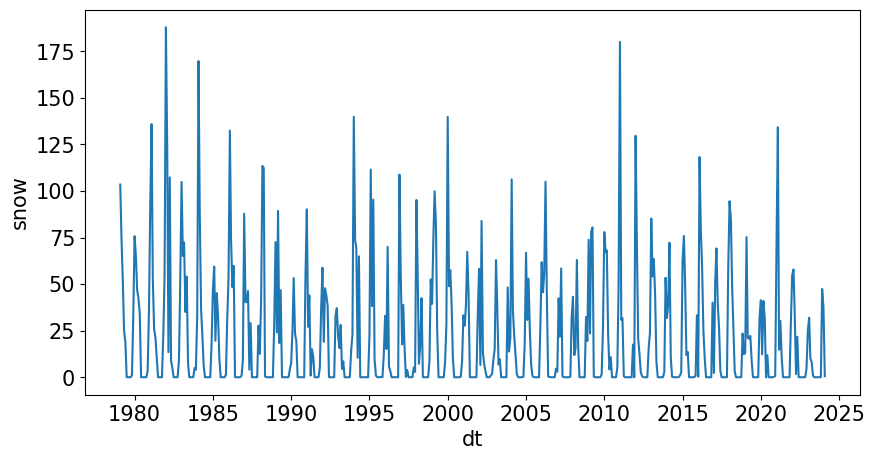

In [101]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_df, x=monthly_df.index, y='snow');

### Checking seasonality

Using the augmented Dicker-Fuller test to check the seasonality of the distribution, which obviously should be. However, the p-value is still below 5%.

In [102]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(monthly_df.snow)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.196238705366489
p-value: 0.0006686267887384045


Let's use data from summer 1980 until summer 2021 

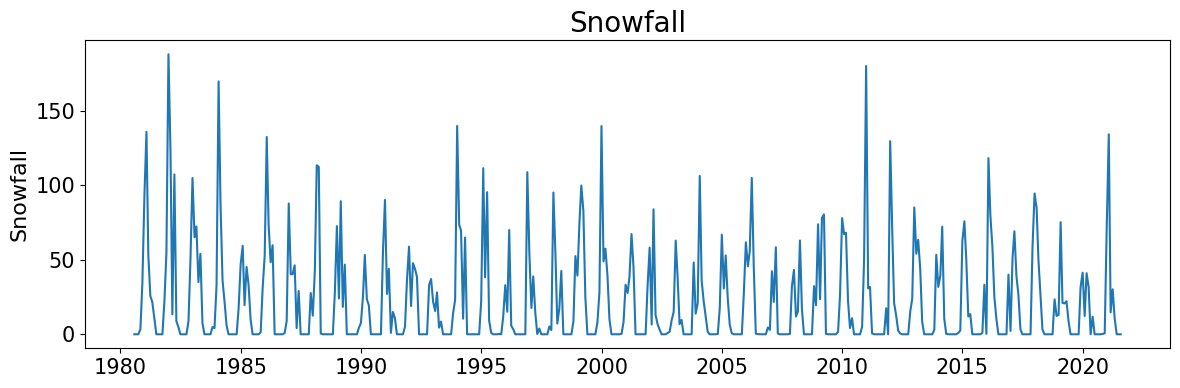

In [103]:
start_date = '1980-07-01'
end_date = '2021-08-01'

variable = 'snow'
y = monthly_df[variable][start_date:end_date]

plt.figure(figsize=(14,4))
plt.plot(y);
plt.title('Snowfall', fontsize=20);
plt.ylabel('Snowfall', fontsize=16);

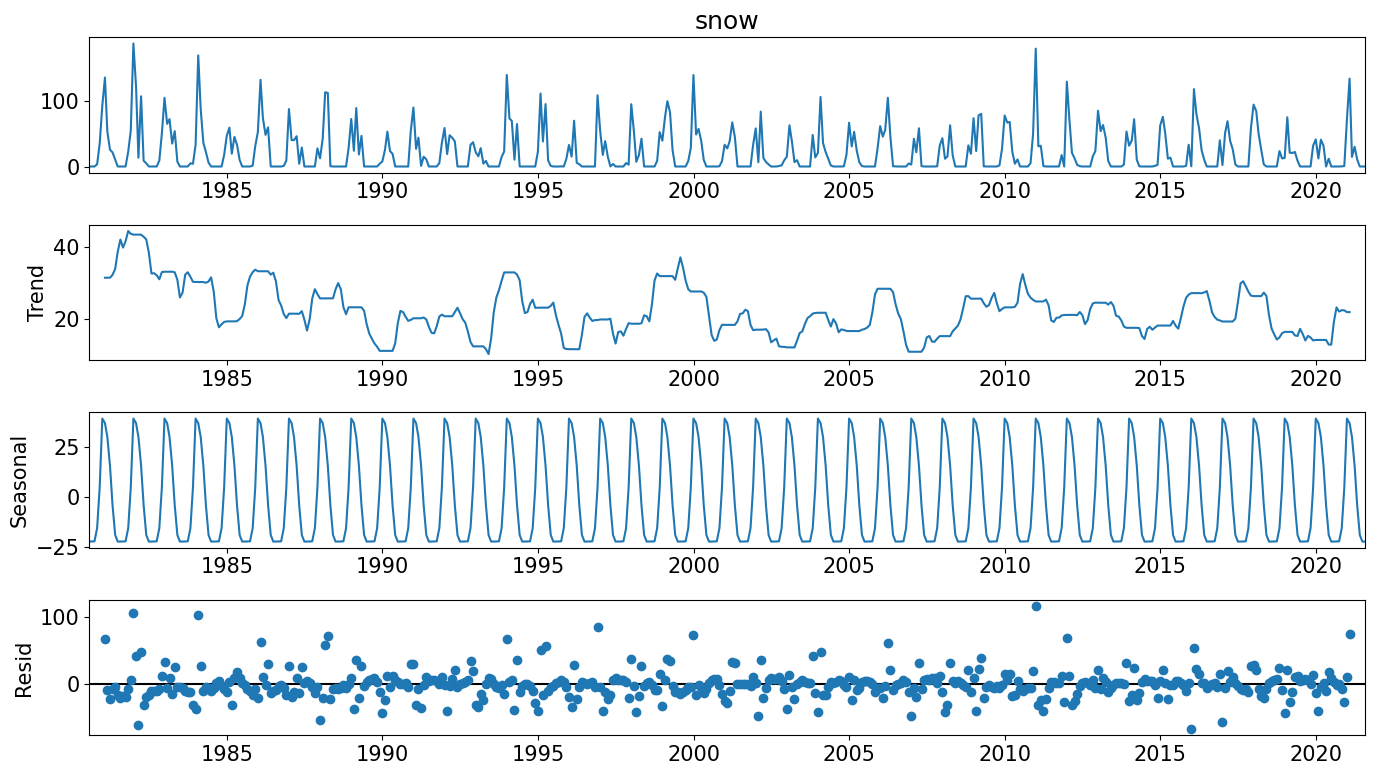

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)
result = seasonal_decompose(y,model='additive')
fig = result.plot()

### First approach using an auto-arima model

In [13]:
import pmdarima as pm

model = pm.auto_arima(
    y,
    m=12, # frequency of series. Important to choose manually
    seasonal=True,
    stepwise=True,  # only check the most interesting combination. False will take way longer.
    start_p=0, max_p=2,
    start_d=0, max_d=2,
    start_q=0, max_q=2,
    start_P=0, max_P=2,
    start_D=0, max_D=2,
    start_Q=0, max_Q=2,
    njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4845.239, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4665.559, Time=1.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4707.185, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5029.316, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4728.717, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4606.923, Time=3.25 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=7.38 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.74 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=4614.458, Time=3.06 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=4608.214, Time=4.65 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=4607.023, Time=4.30 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=4606.214, Time=3.16 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=4667.720, Time=0.93 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept

Let's predict snow for year 2022

In [30]:
results = model.fit(y)
predictions = results.predict(n_periods=12)

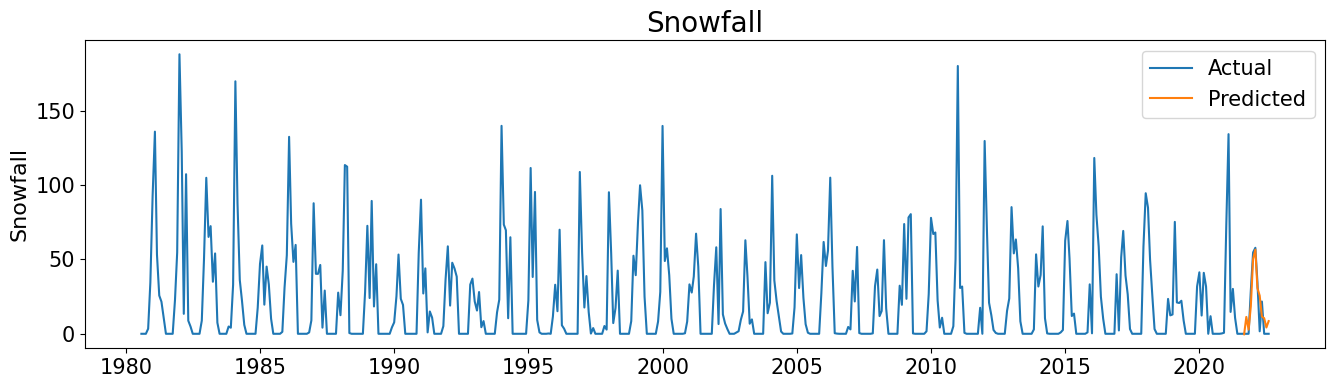

In [31]:
plt.figure(figsize=(16,4))
plt.plot(monthly_df["snow"][start_date:'2022-08-01'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Snowfall', fontsize=20)
plt.ylabel('Snowfall', fontsize=16)
plt.legend()

## First observations
We observe a decreasing tendency of the total quantity of snow year after year and an increasing tendency of the average temperature. So far the SARIMAX model is predicting well for one year.